# I. Set Up

In [13]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import umap
import seaborn as sns
import fnmatch
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('Full', 'All', 'New', 'Bona'), value='Full')

# II. Load Data

In [14]:
# Set ID
set_id = set_widget.value
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist*nE16*nt24*ndt16*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='Histogram File :',disabled=False); input_widget



Dropdown(description='Histogram File :', options=('hist3D-Full-nE16-nt24-ndt16-normnone.pkl', 'hist3D-Full-nE1…

In [15]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

Number of Features:  95473
Number of Property Sets:  95473


# III. CLUSTERING

In [16]:
files = os.listdir(f'{global_path}/{set_id}/')
tsne_files = [f for f in files if fnmatch.fnmatch(f, 'tsne*hist3D*nE16*perp125*lr*PCA22*rs505.csv')]
tsne_widget = widgets.Dropdown(options=tsne_files[:],value=tsne_files[0],description='TSNE File :',disabled=False); tsne_widget

Dropdown(description='TSNE File :', options=('tsne-Full-hist3D-Full-nE16-nt24-ndt16-normnone-2D-perp125-lr250-…

In [17]:
import hdbscan 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Load 
tsne_file = tsne_widget.value
df_tsne = pd.read_csv(f'{global_path}/{set_id}/{tsne_file}')
# Filter on variability
df_properties_filter = df_properties#.loc[df_properties["var_prob_m"] >= 0.8]
filter_ids = df_properties_filter["obsreg_id"]
df_tsne_filter = df_tsne[df_tsne["obsreg_id"].isin(filter_ids)]
tsne12 = df_tsne_filter[['tsne1', 'tsne2']].values

In [24]:
print(tsne_file[:-4])

tsne-Full-hist3D-Full-nE16-nt24-ndt16-normnone-2D-perp125-lr175-ee1-it2000-PCA22-initrandom-rs505


In [8]:
# Run DBSCAN
eps = 1
ms = 30
dbscan=DBSCAN(eps=eps,min_samples = ms)
clusters=dbscan.fit(tsne12)
labels=clusters.labels_
n_clusters = len(set(labels))- (1 if -1 in labels else 0)
df_tsne_filter['cluster'] = labels

# Save TSNE Output
df_tsne_filter.to_csv(f'{global_path}/{set_id}/DBSCANres-{set_id}-{tsne_file[:-4]}-EPS{eps}-MS{ms}.csv', index=False)

#Display Performance
silhouette_avg = silhouette_score(tsne12, labels)
ch_score = calinski_harabasz_score(tsne12, labels)
db_score = davies_bouldin_score(tsne12, labels)
print("Calinski-Harabasz Index: ", ch_score)
print("Davies-Bouldin Index: ", db_score)
print("Silhouette score:", silhouette_avg)
print("Number of Clusters:", n_clusters)


Calinski-Harabasz Index:  683.1731223374802
Davies-Bouldin Index:  3.354960659149763
Silhouette score: -0.39581766351658515
Number of Clusters: 27


SHOW

In [10]:
# Load DBSCAN RESULT
files = os.listdir(f'{global_path}/{set_id}/')
dbscan_files = [f for f in files if fnmatch.fnmatch(f, 'DBSCANres*csv')]
dbscan_widget = widgets.Dropdown(options=dbscan_files[:],value=dbscan_files[0],description='TSNE File :',disabled=False); dbscan_widget

Dropdown(description='TSNE File :', options=('DBSCANres-Full-tsne-Full-hist3D-Full-nE16-nt24-ndt16-normnone-2D…

In [18]:
# Load the DataFrame from the CSV file
dbscan_file = dbscan_widget.value
df_tsne_filter = pd.read_csv(f'{global_path}/{set_id}/{dbscan_file}')

#####SELECTED ANOMALIES
dip_in_blip = ['14431_16']
dips_select = ['10783_10','10871_10','11059_10','9070_10','9072_10','11272_13','10783_10','13682_9','1708_192','1708_193','1712_91','15553_237','13681_9','13813_86','11988_38','13814_586','13812_586','13828_596','13828_46']
dips_maybe = ['12992_101','12995_101','13814_586','13813_218','13814_237','13828_596']
flares_select = ['10542_331','4395_992','2227_220','16444_1025','14368_503','14431_16','14542_18','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','9109_333','9109_344','13637_1078','14368_489','1042_24','11016_168','11737_157','12390_136']
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
rosanne = ['13814_567']
ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']
caleb = ['13812_86','13813_86','793_107','808_47','4733_229','4736_81','4737_74','5322_229'] #,'4737_21','934_23','5309_17']
caleb_flares = ['1586_59','9533_24']
lin = ['4062_31', '13454_56','20635_58'] 
irwin = ['3926_13','7800_4','7799_16','8490_30']
xue = ['957_208', '3389_274']
goulding_nandra = ['9875_166', '9456_274', '5849_62', '8636_2', '8636_3'] # last one not listed
civian_marchesi = ['8021_33'] 
not_liste_xue = ['15211_44', '15211_3']


tsne_flares = df_tsne_filter.loc[df_tsne_filter['obsreg_id'].isin(flares_select+flares_maybe)]
tsne_dips = df_tsne_filter.loc[df_tsne_filter['obsreg_id'].isin(dips_select + dips_maybe)]
tsne_rosanne = df_tsne_filter.loc[df_tsne_filter['obsreg_id'].isin(rosanne + ieva )]
tsne_lin_irwin = df_tsne_filter.loc[df_tsne_filter['obsreg_id'].isin(lin + irwin + xue + goulding_nandra + civian_marchesi )]

anomalies = pd.concat([tsne_flares, tsne_dips, tsne_rosanne, tsne_lin_irwin])
anomalies.head(50)

,tsne1,tsne2,obsreg_id,cluster
1075,-7.978623,-22.714432,1042_24,0
2747,18.668257,-26.958855,10822_185,0
3806,0.411572,-51.761482,11016_168,1
6204,20.340710,-36.003300,11737_157,5
9587,4.780437,-42.325090,12390_136,1
14918,31.454730,-38.859450,13610_112,3
20506,3.824997,-51.257652,14368_489,1
20511,15.788480,-42.377270,14368_503,1
21057,2.046209,-49.869476,14431_16,1
21915,4.296730,-46.023640,14542_18,1


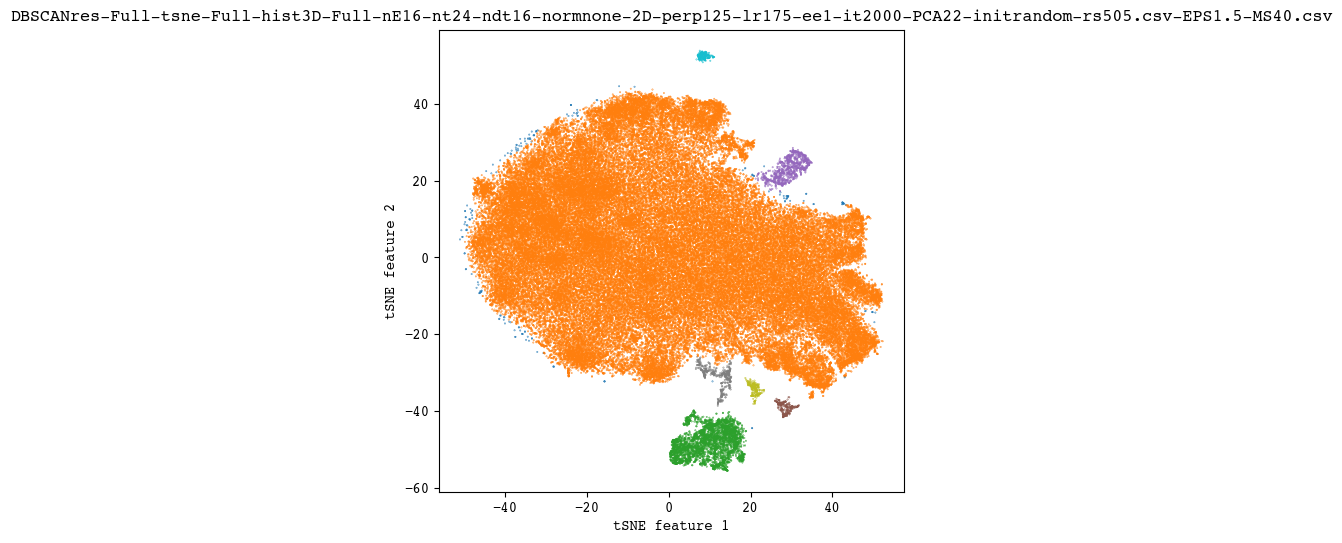

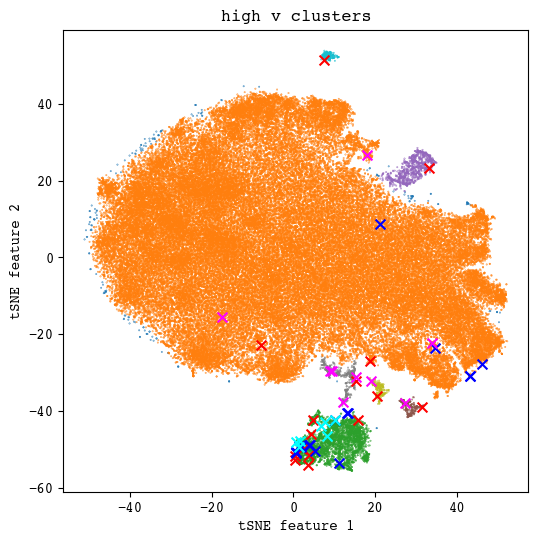

In [19]:
# PLOT
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], cmap = 'tab10', s=0.1)
axs.set_xlabel('tSNE feature 1')
axs.set_ylabel('tSNE feature 2')
axs.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]

fig, axs2 = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
cluster = axs2.scatter(df_tsne_filter['tsne1'], df_tsne_filter['tsne2'],c=df_tsne_filter['cluster'], cmap = 'tab10', s=0.1)
axs2.set_xlabel('tSNE feature 1')
axs2.set_ylabel('tSNE feature 2')
axs2.set_title(f'high v clusters')
unique_clusters = df_tsne_filter['cluster'].unique()
legend_labels = [f"Cluster {cluster_id}" for cluster_id in unique_clusters]
axs2.scatter(tsne_flares['tsne1'], tsne_flares['tsne2'], c='red', marker='x', s=50, label='Flares')
axs2.scatter(tsne_dips['tsne1'], tsne_dips['tsne2'], c='blue', marker='x', s=50, label='Dips')
axs2.scatter(tsne_rosanne['tsne1'], tsne_rosanne['tsne2'], c='cyan', marker='x', s=50, label='Rosanne')
axs2.scatter(tsne_lin_irwin['tsne1'], tsne_lin_irwin['tsne2'], c='magenta', marker='x', s=50, label='Others')
# axs2.legend(cluster.legend_elements()[0], legend_labels)
axs.set_title(dbscan_file)


plt.show()
